# Twitter US Airline Sentiment

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

### Objective

To implement the techniques learnt as a part of the course.

## 1. Import the libraries, load dataset, print shape of data, data description

### Imports

In [1]:
# Import libraries

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import re, string, unicodedata
import numpy as np
import pandas as pd
from IPython.core.display import display, HTML
import itertools

In [3]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [4]:
import contractions
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kvijayak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from yellowbrick.classifier import ClassificationReport, ROCAUC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score

In [6]:
# Increase cell width
display(HTML("<style>.container { width:98% !important; }</style>"))
pd.set_option("display.max_colwidth", None)
my_random_state = 5
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams["axes.grid"] = False

### Read Data

In [7]:
# Read the tweets from CSV file
twitter_full_data = pd.read_csv("tweets.csv")

### Shape of Data

In [8]:
# Print the shape of the data
twitter_full_data.shape

(14640, 15)

### Data Description

In [9]:
# The raw data with all the columns

print("")
print("Twitter Full Data")
print("*****************")
print("")
display(HTML(twitter_full_data.head(5).to_html()))


Twitter Full Data
*****************



,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [10]:
print("")
print("Twitter Full Data -- Info")
print(twitter_full_data.info())


Twitter Full Data -- Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 146

##### Observation
* dataset has **14640** entries and **15** features
* But some of the columns dont have values for all the rows.
* **airline_sentiment** and **text** are the essential columns and there are no nulls in that column

## 2. Understand of data-columns

### Drop Non-Essential Columns

In [11]:
twitter_data = twitter_full_data[["text", "airline_sentiment"]]

### Shape after dropping columns

In [12]:
twitter_data.shape

(14640, 2)

### Value Counts

In [13]:
twitter_data["airline_sentiment"].value_counts(normalize=True)*100

negative    62.691257
neutral     21.168033
positive    16.140710
Name: airline_sentiment, dtype: float64

##### Observation
* The dataset has about **62%** data for **negative** sentiments and only **21%** and **16%** for neutral and positive sentiments
* This clearly show that there is a data imbalance, making it harder for the classifiers to learn neutral and positive sentiments.

### Null Values

In [14]:
twitter_data.isnull().sum(axis=0)

text                 0
airline_sentiment    0
dtype: int64

### NA Values

In [15]:
twitter_data.isna().sum(axis=0)

text                 0
airline_sentiment    0
dtype: int64

##### Observation
* We dont have null or NA values for the two essential columns

### Print first 5 rows

In [16]:
print("")
print("Twitter Data")
print("************")
print("")
display(HTML(twitter_data.head(5).to_html()))


Twitter Data
************



,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative


## 3. Text pre-processing: Data preparation

### Html tag removal

In [17]:
# remove the html tags, if any, from the data
def strip_html(text):
    return BeautifulSoup(text, "html.parser").get_text()

In [18]:
twitter_data["text"] = twitter_data["text"].apply(lambda x : strip_html(x))

In [19]:
display(HTML(twitter_data.head(5).to_html()))

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative


### Contractions

In [20]:
# remove any contractions in the data (eg: you've will be converted to you have)
def replace_contractions(text):
    return contractions.fix(text)

In [21]:
twitter_data["text"] = twitter_data["text"].apply(lambda x : replace_contractions(x))

In [22]:
display(HTML(twitter_data.head(5).to_html()))

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you have added commercials to the experience... tacky.,positive
2,@VirginAmerica I did not today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",negative
4,@VirginAmerica and it is a really big bad thing about it,negative


### Tokenization

In [23]:
# tokenize the data
def tokenize(text):
    return word_tokenize(text)

In [24]:
twitter_data["text"] = twitter_data["text"].apply(lambda x : tokenize(x))

In [25]:
display(HTML(twitter_data.head(5).to_html()))

,text,airline_sentiment
0,"[@, VirginAmerica, What, @, dhepburn, said, .]",neutral
1,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]",positive
2,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]",neutral
3,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]",negative
4,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]",negative


### Remove Numbers

In [26]:
# remove any numbers in the data
def remove_numbers(text):
    numberless_words = []
    for token in text:
        numberless_word = re.sub(r'\d+', '', token)
        numberless_words.append(numberless_word)
    return numberless_words

In [27]:
twitter_data["text"] = twitter_data["text"].apply(lambda x : remove_numbers(x))

In [28]:
display(HTML(twitter_data.head(5).to_html()))

,text,airline_sentiment
0,"[@, VirginAmerica, What, @, dhepburn, said, .]",neutral
1,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]",positive
2,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]",neutral
3,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]",negative
4,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]",negative


### Removal of Special Characters and Punctuations

In [29]:
# remove special/non-ascii characters
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# remove punctuations
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

In [30]:
twitter_data["text"] = twitter_data["text"].apply(lambda x : remove_non_ascii(x))
twitter_data["text"] = twitter_data["text"].apply(lambda x : remove_punctuation(x))

In [31]:
display(HTML(twitter_data.head(5).to_html()))

,text,airline_sentiment
0,"[VirginAmerica, What, dhepburn, said]",neutral
1,"[VirginAmerica, plus, you, have, added, commercials, to, the, experience, tacky]",positive
2,"[VirginAmerica, I, did, not, today, Must, mean, I, need, to, take, another, trip]",neutral
3,"[VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]",negative
4,"[VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]",negative


### Conversion to lowercase

In [32]:
# convert data to lowercase
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

In [33]:
twitter_data["text"] = twitter_data["text"].apply(lambda x : to_lowercase(x))

In [34]:
display(HTML(twitter_data.head(5).to_html()))

,text,airline_sentiment
0,"[virginamerica, what, dhepburn, said]",neutral
1,"[virginamerica, plus, you, have, added, commercials, to, the, experience, tacky]",positive
2,"[virginamerica, i, did, not, today, must, mean, i, need, to, take, another, trip]",neutral
3,"[virginamerica, it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]",negative
4,"[virginamerica, and, it, is, a, really, big, bad, thing, about, it]",negative


### Lemmatize or stemming

In [35]:
# Lemmatize the data
lemmatizer = WordNetLemmatizer()
    
def lemmatize_list(words):
    new_words = []
    for word in words:
        new_words.append(lemmatizer.lemmatize(word))
    return new_words

In [36]:
twitter_data["text"] = twitter_data["text"].apply(lambda x : lemmatize_list(x))

In [37]:
display(HTML(twitter_data.head(5).to_html()))

,text,airline_sentiment
0,"[virginamerica, what, dhepburn, said]",neutral
1,"[virginamerica, plus, you, have, added, commercial, to, the, experience, tacky]",positive
2,"[virginamerica, i, did, not, today, must, mean, i, need, to, take, another, trip]",neutral
3,"[virginamerica, it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guest, face, they, have, little, recourse]",negative
4,"[virginamerica, and, it, is, a, really, big, bad, thing, about, it]",negative


### Join the words

In [38]:
# Join the tokens back to text string
def join_words(words):
    return " ".join(words)

In [39]:
twitter_data["text"] = twitter_data["text"].apply(lambda x : join_words(x))

### Print 5 rows after preprocessing

In [40]:
print("")
print("Twitter Data")
print("************")
print("")
display(HTML(twitter_data.head(5).to_html()))


Twitter Data
************



,text,airline_sentiment
0,virginamerica what dhepburn said,neutral
1,virginamerica plus you have added commercial to the experience tacky,positive
2,virginamerica i did not today must mean i need to take another trip,neutral
3,virginamerica it is really aggressive to blast obnoxious entertainment in your guest face they have little recourse,negative
4,virginamerica and it is a really big bad thing about it,negative


## 4. Vectorization

### CountVectorizer

In [41]:
count_vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 5000)
twitter_data_count_vector_features = count_vectorizer.fit_transform(twitter_data["text"])
twitter_data_count_vector_features = twitter_data_count_vector_features.toarray()

In [42]:
count_vectorizer.vocabulary_

{'virginamerica': 4766,
 'what': 4859,
 'said': 3775,
 'plus': 3306,
 'you': 4980,
 'have': 1954,
 'added': 49,
 'commercial': 908,
 'to': 4486,
 'the': 4413,
 'experience': 1515,
 'did': 1237,
 'not': 2978,
 'today': 4488,
 'must': 2864,
 'mean': 2707,
 'need': 2898,
 'take': 4334,
 'another': 187,
 'trip': 4551,
 'it': 2283,
 'is': 2276,
 'really': 3530,
 'aggressive': 90,
 'blast': 492,
 'obnoxious': 3024,
 'entertainment': 1432,
 'in': 2146,
 'your': 4984,
 'guest': 1909,
 'face': 1545,
 'they': 4428,
 'little': 2536,
 'recourse': 3551,
 'and': 164,
 'big': 461,
 'bad': 350,
 'thing': 4430,
 'about': 9,
 'seriously': 3888,
 'would': 4937,
 'pay': 3197,
 'flight': 1657,
 'for': 1706,
 'seat': 3838,
 'that': 4412,
 'this': 4434,
 'playing': 3296,
 'only': 3075,
 'flying': 1684,
 'va': 4727,
 'yes': 4973,
 'nearly': 2895,
 'every': 1477,
 'time': 4467,
 'fly': 1679,
 'vx': 4782,
 'will': 4880,
 'go': 1863,
 'away': 332,
 'missed': 2795,
 'prime': 3390,
 'opportunity': 3094,
 'men': 27

In [43]:
twitter_data_count_vector_features.shape

(14640, 5000)

### TfidfVectorizer

In [44]:
tfidf_vectorizer = TfidfVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 5000)
twitter_data_tdidf_features = tfidf_vectorizer.fit_transform(twitter_data["text"])
twitter_data_tdidf_features = twitter_data_tdidf_features.toarray()

In [45]:
tfidf_vectorizer.vocabulary_

{'virginamerica': 4766,
 'what': 4859,
 'said': 3775,
 'plus': 3306,
 'you': 4980,
 'have': 1954,
 'added': 49,
 'commercial': 908,
 'to': 4486,
 'the': 4413,
 'experience': 1515,
 'did': 1237,
 'not': 2978,
 'today': 4488,
 'must': 2864,
 'mean': 2707,
 'need': 2898,
 'take': 4334,
 'another': 187,
 'trip': 4551,
 'it': 2283,
 'is': 2276,
 'really': 3530,
 'aggressive': 90,
 'blast': 492,
 'obnoxious': 3024,
 'entertainment': 1432,
 'in': 2146,
 'your': 4984,
 'guest': 1909,
 'face': 1545,
 'they': 4428,
 'little': 2536,
 'recourse': 3551,
 'and': 164,
 'big': 461,
 'bad': 350,
 'thing': 4430,
 'about': 9,
 'seriously': 3888,
 'would': 4937,
 'pay': 3197,
 'flight': 1657,
 'for': 1706,
 'seat': 3838,
 'that': 4412,
 'this': 4434,
 'playing': 3296,
 'only': 3075,
 'flying': 1684,
 'va': 4727,
 'yes': 4973,
 'nearly': 2895,
 'every': 1477,
 'time': 4467,
 'fly': 1679,
 'vx': 4782,
 'will': 4880,
 'go': 1863,
 'away': 332,
 'missed': 2795,
 'prime': 3390,
 'opportunity': 3094,
 'men': 27

In [46]:
twitter_data_tdidf_features.shape

(14640, 5000)

## 5. Fit and Evaluate

In [47]:
# Capture the label for the data
twitter_data_labels = twitter_data["airline_sentiment"]

In [48]:
# Create a dataframe to store the outputs
result_column_names = ["Model", "Cross Val Score", "Accuracy"]
model_comp_df = pd.DataFrame(columns = result_column_names)
labels = ["positive", "neutral", "negative"]

In [49]:
# Method to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Using CountVectorizer

In [50]:
# Split the data into training and test sets
X_count_train, X_count_test, y_count_train, y_count_test = train_test_split(twitter_data_count_vector_features, twitter_data_labels, test_size=0.3, random_state=my_random_state)

#### CountVectorizer - Random Forest

In [51]:
# User RandomForest Classifier to classify the tweets
count_random_forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
count_random_forest = count_random_forest.fit(X_count_train, y_count_train)

# Compute the cross validation score
count_random_cross_val_score = np.mean(cross_val_score(count_random_forest, twitter_data_count_vector_features, twitter_data_labels, cv=5))

In [52]:
# Predict
count_vector_random_result = count_random_forest.predict(X_count_test)

# Calculate the accuracy
count_vector_random_acc = accuracy_score(y_count_test, count_vector_random_result)

In [53]:
model_comp_df.loc[0] = ["Count Vectorizer - Random Forest", count_random_cross_val_score, count_vector_random_acc]
display(HTML(model_comp_df.to_html()))

,Model,Cross Val Score,Accuracy
0,Count Vectorizer - Random Forest,0.710587,0.747723


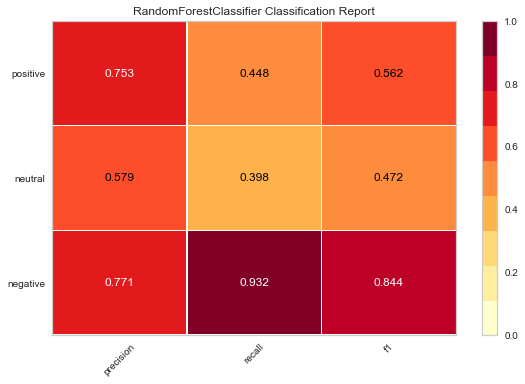

In [54]:
# Visualize the Classification Report
viz = ClassificationReport(RandomForestClassifier(n_estimators=10, n_jobs=4))
viz.fit(X_count_train, y_count_train)
viz.score(X_count_test, y_count_test)
viz.show();

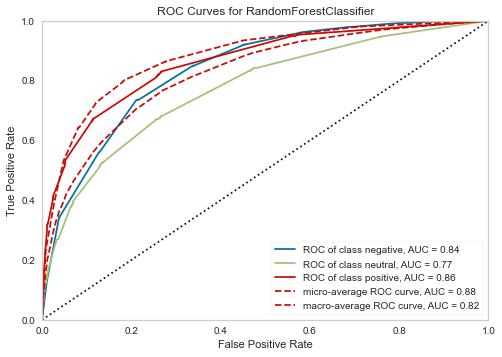

In [55]:
# Create an ROCAUC curve plot
roc = ROCAUC(RandomForestClassifier(n_estimators=10, n_jobs=4))
roc.fit(X_count_train, y_count_train)
roc.score(X_count_test, y_count_test)
roc.show();

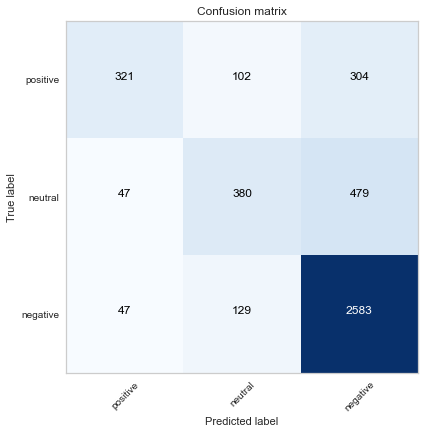

In [56]:
# Form the confusion matrix
count_vector_conf_mat = confusion_matrix(y_count_test, count_vector_random_result, labels=labels)
plot_confusion_matrix(count_vector_conf_mat, classes = labels) 

#### CountVectorizer - Bagging

In [57]:
# Use Bagging Classifer
count_bagging = BaggingClassifier(n_estimators=10, n_jobs=4, max_samples= .7, bootstrap=True, oob_score=True, random_state=my_random_state)
count_bagging = count_bagging.fit(X_count_train, y_count_train)

# Compute the cross validaton score
count_bagging_cross_val_score = np.mean(cross_val_score(count_bagging, twitter_data_count_vector_features, twitter_data_labels, cv=5))

In [58]:
# Predict and calculate the accuracy
count_vector_bagging_result = count_bagging.predict(X_count_test)
count_vector_bagging_acc = accuracy_score(y_count_test, count_vector_bagging_result)

In [59]:
model_comp_df.loc[1] = ["Count Vectorizer - Bagging", count_bagging_cross_val_score, count_vector_bagging_acc]
display(HTML(model_comp_df.to_html()))

,Model,Cross Val Score,Accuracy
0,Count Vectorizer - Random Forest,0.710587,0.747723
1,Count Vectorizer - Bagging,0.680464,0.744991


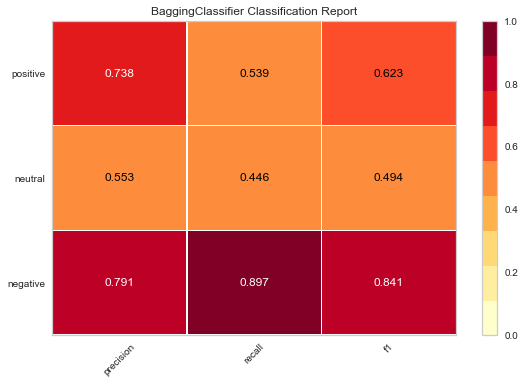

In [60]:
# Visualize the classification report
viz = ClassificationReport(BaggingClassifier(n_estimators=10, n_jobs=4, max_samples= .7, bootstrap=True, oob_score=True, random_state=my_random_state))
viz.fit(X_count_train, y_count_train)
viz.score(X_count_test, y_count_test)
viz.show();

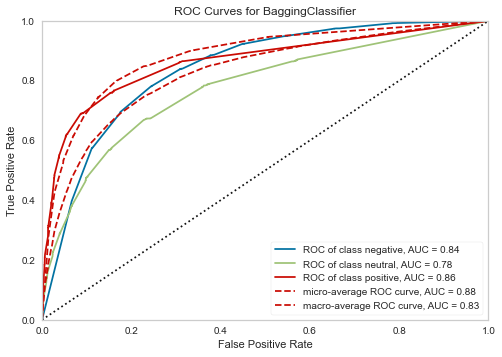

In [61]:
# Plot the ROCAUC curve
roc = ROCAUC(BaggingClassifier(n_estimators=10, n_jobs=4, max_samples= .7, bootstrap=True, oob_score=True, random_state=my_random_state))
roc.fit(X_count_train, y_count_train)
roc.score(X_count_test, y_count_test)
roc.show();

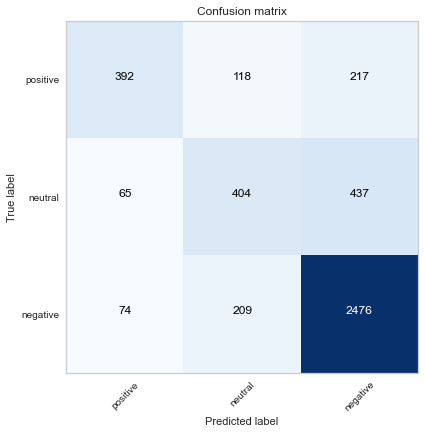

In [62]:
# Form the confusion matrix
count_vector_conf_mat = confusion_matrix(y_count_test, count_vector_bagging_result, labels=labels)
plot_confusion_matrix(count_vector_conf_mat, classes = labels) 

### Using TfidfVectorizer

In [63]:
# Split the data into training and test set for Tfidf Vectorization
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(twitter_data_tdidf_features, twitter_data_labels, test_size=0.3, random_state=my_random_state)

#### TfidfVectorizer - Random Forest

In [64]:
# Use Random Forest Classifier 
tfidf_random_forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
tfidf_random_forest = tfidf_random_forest.fit(X_tfidf_train, y_tfidf_train)

# Compute the cross validation score
tfidf_random_cross_val_score = np.mean(cross_val_score(tfidf_random_forest, twitter_data_tdidf_features, twitter_data_labels, cv=5))

In [65]:
# Predict and calculate the accuracy score
tfidf_random_result = tfidf_random_forest.predict(X_tfidf_test)
tfidf_random_acc = accuracy_score(y_tfidf_test, tfidf_random_result)

In [66]:
model_comp_df.loc[2] = ["Tfidf Vectorizer - Random Forest", tfidf_random_cross_val_score, tfidf_random_acc]
display(HTML(model_comp_df.to_html()))

,Model,Cross Val Score,Accuracy
0,Count Vectorizer - Random Forest,0.710587,0.747723
1,Count Vectorizer - Bagging,0.680464,0.744991
2,Tfidf Vectorizer - Random Forest,0.701434,0.732013


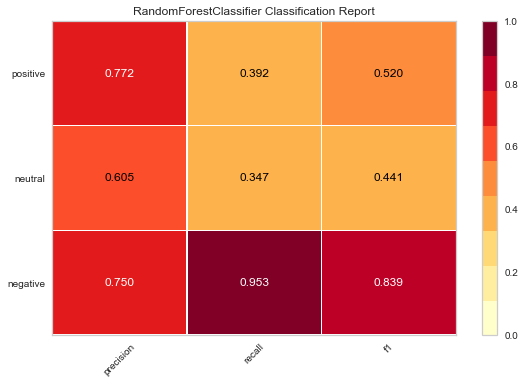

In [67]:
# Visualize the classification report
viz = ClassificationReport(RandomForestClassifier(n_estimators=10, n_jobs=4))
viz.fit(X_tfidf_train, y_tfidf_train)
viz.score(X_tfidf_test, y_tfidf_test)
viz.show();

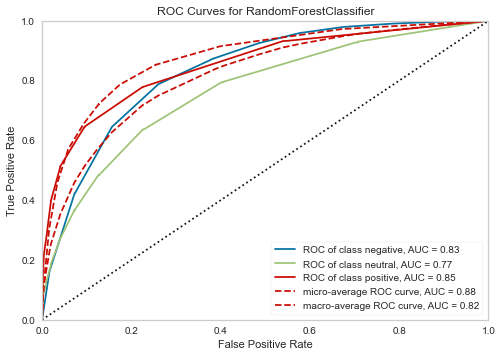

In [68]:
# Plot the ROCAUC score
roc = ROCAUC(RandomForestClassifier(n_estimators=10, n_jobs=4))
roc.fit(X_tfidf_train, y_tfidf_train)
roc.score(X_tfidf_test, y_tfidf_test)
roc.show();

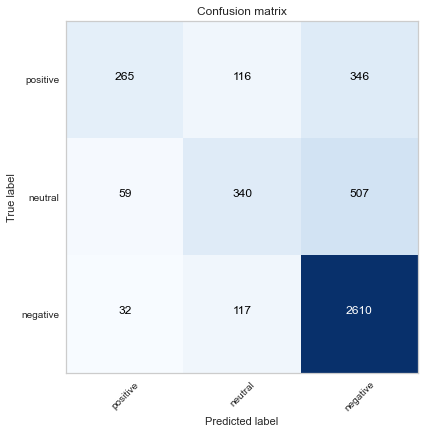

In [69]:
# Form the confusion matrix
tfidf_conf_mat = confusion_matrix(y_tfidf_test, tfidf_random_result, labels=labels)
plot_confusion_matrix(tfidf_conf_mat, classes = labels) 

#### TfidfVectorizer - Bagging

In [70]:
# Use BaggingClassifier
tfidf_bagging = BaggingClassifier(n_estimators=10, n_jobs=4, max_samples= .7, bootstrap=True, oob_score=True, random_state=my_random_state)
tfidf_bagging = tfidf_bagging.fit(X_tfidf_train, y_tfidf_train)

# Calculate the cross validation score
tfidf_bagging_cross_val_score = np.mean(cross_val_score(tfidf_bagging, twitter_data_count_vector_features, twitter_data_labels, cv=5))

In [71]:
# Predict and calculate the accuracy score
tfidf_bagging_result = tfidf_bagging.predict(X_tfidf_test)
tfidf_bagging_acc = accuracy_score(y_tfidf_test, tfidf_bagging_result)

In [72]:
model_comp_df.loc[3] = ["Tfidf Vectorizer - Bagging", tfidf_bagging_cross_val_score, tfidf_bagging_acc]
display(HTML(model_comp_df.to_html()))

,Model,Cross Val Score,Accuracy
0,Count Vectorizer - Random Forest,0.710587,0.747723
1,Count Vectorizer - Bagging,0.680464,0.744991
2,Tfidf Vectorizer - Random Forest,0.701434,0.732013
3,Tfidf Vectorizer - Bagging,0.680464,0.746812


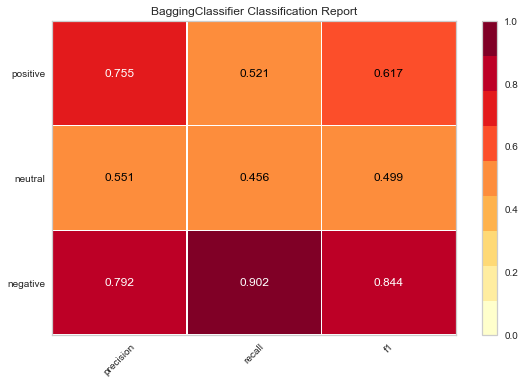

In [73]:
# Visualize the classification report
viz = ClassificationReport(BaggingClassifier(n_estimators=10, n_jobs=4, max_samples= .7, bootstrap=True, oob_score=True, random_state=my_random_state))
viz.fit(X_tfidf_train, y_tfidf_train)
viz.score(X_tfidf_test, y_tfidf_test)
viz.show();

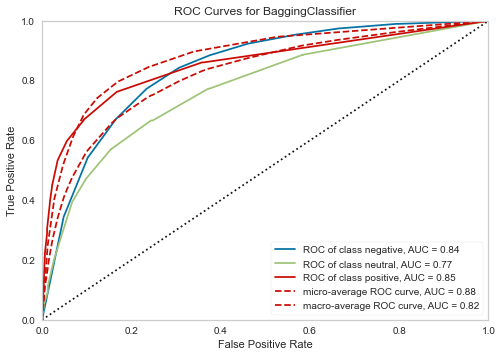

In [74]:
# Plot the ROCAUC curve
roc = ROCAUC(BaggingClassifier(n_estimators=10, n_jobs=4, max_samples= .7, bootstrap=True, oob_score=True, random_state=my_random_state))
roc.fit(X_tfidf_train, y_tfidf_train)
roc.score(X_tfidf_test, y_tfidf_test)
roc.show();

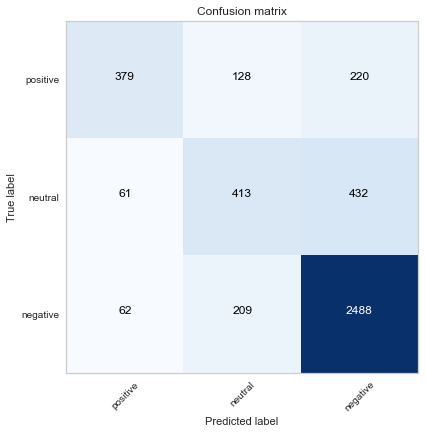

In [75]:
# Form the confusion matrix
tfidf_conf_mat = confusion_matrix(y_tfidf_test, tfidf_bagging_result, labels=labels)
plot_confusion_matrix(tfidf_conf_mat, classes = labels) 

## 6. Summary

* We use dataset which has tweets in text format and their captured sentiment (positive, negative or neutral)
* The goal was to build a model for sentiment analysis, using classification


* We pre-processed the data to make it ready for the classifier:
    * We first removed all the non-essential columns
    * We removed any HTML specific tags in the data, if any (this could be some artificats as a result of scraping of data). They generally have no relevancy for sentiment analysis
    * We tokenized the data into individual words (To make it easier for further processing)
    * We removed any numbers, special characters and punctuations from the tokens, as they dont have extra value for sentiment analysis in this context
    * We converted the works to lower case, to make sure the corpus doesnt have any duplicate words with different casing
    * Then we lemmatized the words to their root form, to normalize the various forms of the same word
    * We joined the processed words back to text strings for further processing for classification


* Once the words were pre-processed, then we had to convert the string representation of words to numbers, so that any classification algorithm can work on them.
    * For this we used *Count Vectorization* and *Tf-Idf Vectorization*
    * **Count Vectorizer** gave top 5000 most frequet words in the corpus
    * **Tf-Idf Vectorizer** gave top 5000 words. But it takes into account how common words are, across documents. Also it returns floats instead of integer.
    * These techniques gave back numeric representation of the words in the tweets


* With the numeric forms and labels, next we used classification algorthims to train and test the models
* For this purpose, we used RandomForestClassifier and Bagging to classify the tweets
* We then visualized the classification report for each of the classifier we used
* We plotted the ROCAUC curve for the classifier
* We formed the confusion matrix for the classifier


* From the classifier, we observed the following performance


In [76]:
display(HTML(model_comp_df.to_html()))

,Model,Cross Val Score,Accuracy
0,Count Vectorizer - Random Forest,0.710587,0.747723
1,Count Vectorizer - Bagging,0.680464,0.744991
2,Tfidf Vectorizer - Random Forest,0.701434,0.732013
3,Tfidf Vectorizer - Bagging,0.680464,0.746812


* We can see that the Cross Validation Score is the highest for **Random Forest Classifier** using **Count Vectorizer**, at **71%**
* The Accuracy is the highest for **Bagging Classifier**, using **Tf-Idf Vectorizer**

* With more balanced dataset and different pre-processing methods, we might be able to get better performance than what we observe